In [495]:
import os
import glob
import shutil 
import numpy as np 
import pandas as pd
from pathlib import Path

## Get Data

In [496]:
cluster_dir = Path('/Users/carlydrzewiecki/Desktop/trainor_cluster')

In [497]:
sample_data = pd.read_csv(cluster_dir/'7170_INT, dlc.csv', header=None)

## Clean data

In [498]:
### sweep sweep sweep, data clean up

### Rename the columns based on the multi-index set up

for i in range(1, len(sample_data.columns)):
    j = sample_data.iloc[1:4, i:i+1].values
    col_name = str(j[0])+'_'+str(j[1])+'_'+str(j[2])
    col_name = col_name.replace('[', '').replace(']', '').replace("'", '')
    sample_data.rename(columns={i:col_name}, inplace=True)

#Reformat the sample data, remove the multi-index rows
sample_data = sample_data.iloc[4:, :]
sample_data.rename(columns={0:'frame'}, inplace=True)

#Convert the data to floats
sample_data = sample_data.astype(float)

#Replace all instances of individual1 in column names with test_subject
sample_data.columns = sample_data.columns.str.replace('individual1', 'testsubject')
sample_data.columns = sample_data.columns.str.replace('individual2', 'intruder')

#reset the index
sample_data = sample_data.reset_index(drop=True)


In [499]:
#sample_data

In [500]:
col_names = sample_data.columns

body_parts = []

for i, data in enumerate(col_names):
    if i > 0:
        if data.split('_')[1] not in body_parts:
            body_parts.append(data.split('_')[1])

In [501]:
#body_parts

## Calculate distances between dlc markers

In [502]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_distance_between_mice(df, sub1, body_part1, sub2, body_part2):
    return euclidean_distance(df[sub1+'_'+body_part1+'_x'], df[sub1+'_'+body_part1+'_y'], 
    df[sub2+'_'+body_part2+'_x'], df[sub2+'_'+body_part2+'_y'])



In [503]:
#between centroid distance (Falkner does this from top view)
dist_between_mice = get_distance_between_mice(sample_data, 'testsubject', 'midpoint', 'intruder', 'midpoint')

#distance between test subject rear and intruder nose
get_distance_between_mice(sample_data, 'testsubject', 'tailbase', 'intruder', 'nose')

#distance between test subject nose and intruder nose
get_distance_between_mice(sample_data, 'testsubject', 'nose', 'intruder', 'nose')

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
6826           NaN
6827    200.439930
6828    196.993567
6829           NaN
6830    201.345695
Length: 6831, dtype: float64

In [504]:
### Someone should double check my math here
### ALSO I am making the assumption that the edges of the video correspond to the edges of the arena

def get_distance_between_edge(df, sub1, body_part1, edge):
    if edge == 'left':
        return euclidean_distance(df[sub1+'_'+body_part1+'_x'], 0, 0, 0)
    elif edge == 'right':
        return euclidean_distance(df[sub1+'_'+body_part1+'_x'], 0, 1173, 0)
        ## 1173 is the width of the arena in pixels (51 cm long, each cm is 23 pixels)
    elif edge == 'bottom':
        return euclidean_distance(0, df[sub1+'_'+body_part1+'_y'], 0, 0)

In [505]:
dist_from_left_wall = get_distance_between_edge(sample_data, 'testsubject', 'nose', 'left')
dist_from_left_wall = get_distance_between_edge(sample_data, 'testsubject', 'nose', 'right')

#rearing
get_distance_between_edge(sample_data, 'testsubject', 'nose', 'bottom')
get_distance_between_edge(sample_data, 'intruder', 'nose', 'bottom')


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
6826    605.034
6827    608.679
6828    604.995
6829    605.964
6830    604.735
Name: intruder_nose_y, Length: 6831, dtype: float64

<AxesSubplot:>

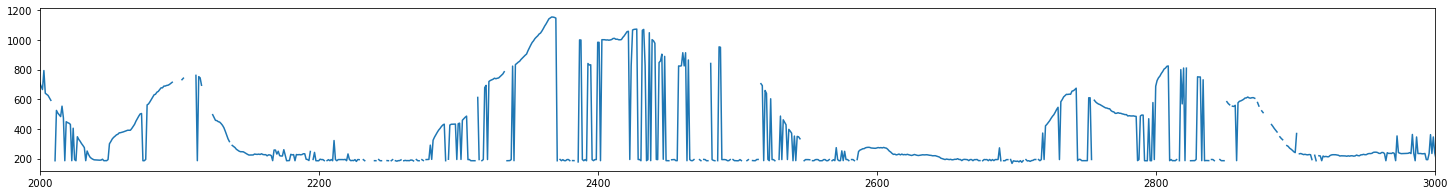

In [506]:
#dist_from_left_wall.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3))
dist_from_left_wall.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3), xlim = (2000, 3000))




<AxesSubplot:>

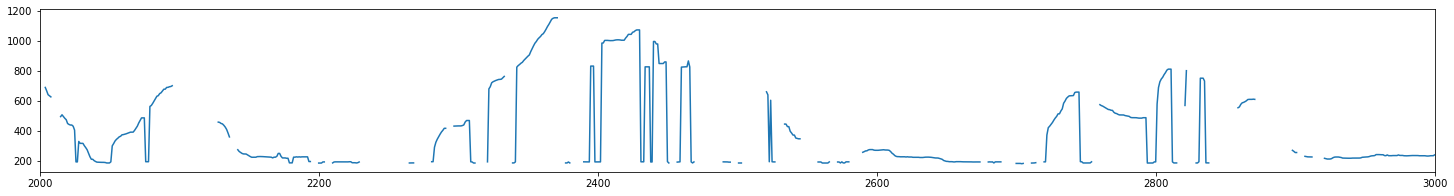

In [507]:
##Should we smooth all the distance data??
left_wall_dist_smoothed = dist_from_left_wall.rolling(5).median()
left_wall_dist_smoothed.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3), xlim = (2000, 3000))



## Velocity

In [508]:
### I am not 100% sure this is correct so someone should double check this

def get_derivative(df, x, y):
    df['dx'] = df[x].diff()
    df['dy'] = df[y].diff()
    #slope = rise/run
    df['dist_traveled_by_frame'] = df['dy']/df['dx']
    return df

In [519]:
def smooth_data(df, window):
    df_smoothed = df.rolling(window).median()
    return df_smoothed

def get_velocity(df, sub1, body_part1):
    dist_list = []
    for i in range(len(df)-1):
        dist_traveled = euclidean_distance(df[sub1+'_'+body_part1+'_x'][i], df[sub1+'_'+body_part1+'_y'][i], df[sub1+'_'+body_part1+'_x'][i+1], df[sub1+'_'+body_part1+'_y'][i+1])
        dist_list.append(dist_traveled)
    dist_df = pd.DataFrame(dist_list)
    #median smooth
    distance_smoothed = smooth_data(dist_df, 3)
    #format this dataset so it makes sense....
    distance_smoothed.columns = ['distance_traveled']
    distance_smoothed['frame'] = df['frame']
    #derive the velocity from the distance traveled over frames
    velocity = get_derivative(distance_smoothed, x = 'frame', y = 'distance_traveled')
    return velocity

def get_velocity_between_mice(df, sub1, body_part1, sub2, body_part2):
    distance = get_distance_between_mice(df, sub1, body_part1, sub2, body_part2)
    dist_df = pd.DataFrame(distance)
    distance_smoothed = smooth_data(dist_df, 3)
    #format this dataset so it makes sense....
    distance_smoothed.columns = ['distance_between_subs']
    distance_smoothed['frame'] = df['frame']
    # #derive the velocity from the distance traveled over frames
    velocity = get_derivative(distance_smoothed, x = 'frame', y = 'distance_between_subs')
    return distance_smoothed

def clean_velocity(df):
    if 'distance_traveled' in df.columns:
        df = df.drop(columns = ['distance_traveled', 'frame', 'dx', 'dy'])
        df['dist_traveled_by_frame'] = df['dist_traveled_by_frame'].abs()
    elif 'distance_between_subs' in df.columns:
        df = df.drop(columns = ['distance_between_subs', 'frame', 'dx', 'dy'])
        #NOTE thaht we do not take the absolute value here 
        # because we want to know if the mice are moving towards or away from each other
        df['dist_traveled_by_frame'] = df['dist_traveled_by_frame']
        #change the column name to be more descriptive
        df.rename(columns={'dist_traveled_by_frame':'dist_between_mice_by_frame'}, inplace=True)
    return df

<AxesSubplot:>

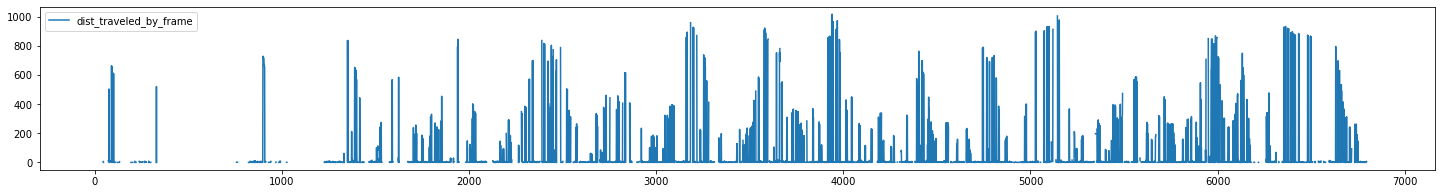

In [520]:
speed_data = get_velocity(sample_data, 'testsubject', 'nose')
velocity = clean_velocity(speed_data)

velocity.plot.line(y = 'dist_traveled_by_frame', figsize = (25, 3))

<AxesSubplot:>

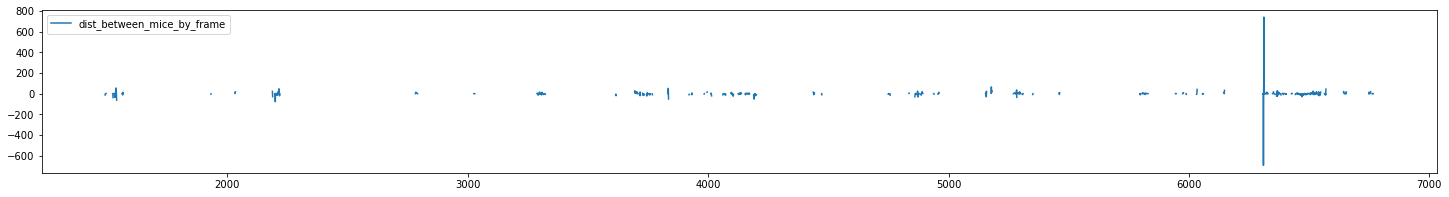

In [521]:
delta_dif_between_mice = get_velocity_between_mice(sample_data, 'testsubject', 'midpoint', 'intruder', 'midpoint')
velocity_between_mice = clean_velocity(delta_dif_between_mice)

velocity_between_mice.plot.line(y ='dist_between_mice_by_frame', figsize = (25, 3))

## Orientation

In [610]:
def get_vector_lengths(df):
    intruder_midpoint = np.array([df['intruder_midpoint_x'], df['intruder_midpoint_y']])
    testsubject_midpoint = np.array([df['testsubject_midpoint_x'], df['testsubject_midpoint_y']])
    testsubject_nose = np.array([df['testsubject_nose_x'], df['testsubject_nose_y']])
    midpoint_to_midpoint = intruder_midpoint - testsubject_midpoint
    midpoint_to_nose = testsubject_nose - testsubject_midpoint
    return midpoint_to_midpoint, midpoint_to_nose

def get_angles(midpoint_to_midpoint, midpoint_to_nose):
    orientation_list = []
    for i in range(midpoint_to_midpoint.shape[1]-1):
        BA = np.reshape(midpoint_to_nose[:,i:i+1], (2,))
        BC = np.reshape(midpoint_to_midpoint[:,i:i+1], (2,))
        cosine_angle = np.dot(BA, BC/ (np.linalg.norm(BA) * np.linalg.norm(BC)))
        angle = np.arccos(cosine_angle)
        orientation_list.append(np.degrees(angle))
    orientation_df = pd.DataFrame(orientation_list)
    orientation_df.columns = ['orientation_to_intruder']
    orientation_df['frame'] = df['frame']
    return orientation_df


### Finds the angle of orientation between the test subject and the intruder
def get_test_orientation_to_intruder(df):
    midpoint_to_midpoint, midpoint_to_nose = get_vector_lengths(df)
    theta = get_angles(midpoint_to_midpoint, midpoint_to_nose)
    return theta

In [611]:
theta = get_test_orientation_to_intruder(sample_data)

<AxesSubplot:>

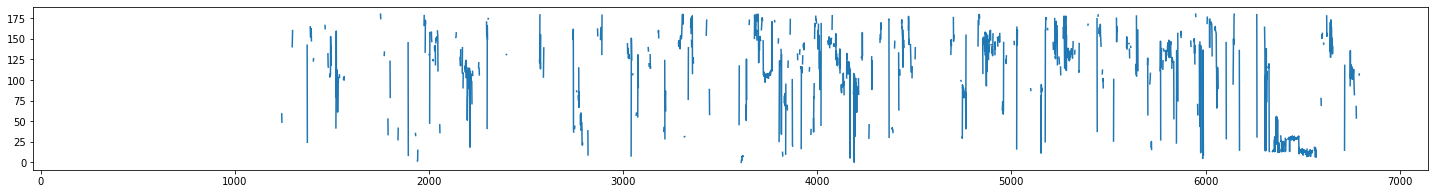

In [613]:
theta['orientation_to_intruder'].plot.line(figsize = (25, 3))

## Shenanigans below....

In [512]:
def find_cross_length(l, h):
    cross = np.sqrt((l**2)+(h**2))
    return cross

In [513]:
find_cross_length(1173, 800)

1419.8341452437323

In [515]:
import sklearn

from scipy.ndimage import gaussian_filter

#sklearn.preprocessing.MinMaxScaler

In [516]:
gaussian_velocity = gaussian_filter(velocity, sigma=1)

<AxesSubplot:>

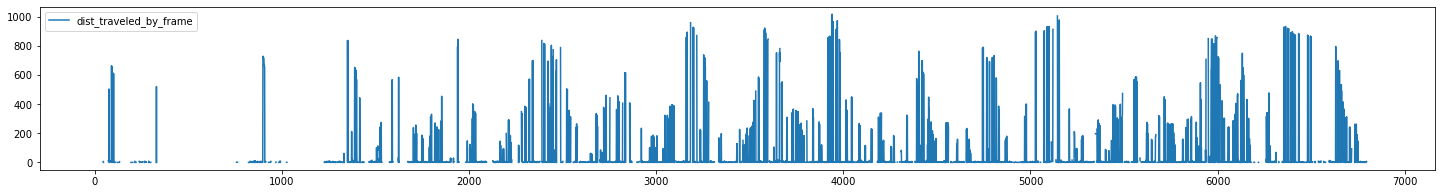

In [517]:
velocity.plot.line(y = 'dist_traveled_by_frame', figsize = (25, 3))

In [518]:
'plot gaussian_velocity here'
gaussian_velocity = pd.DataFrame(gaussian_velocity)

gaussian_velocity.plot.line(y ='dist_between_mice_by_frame', figsize = (25, 3))

KeyError: 'dist_between_mice_by_frame'